# Tarea 2
## Francisco Javier Peralta Ramírez

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from numba import jit

import numpy as np
import sympy as sp
from functools import reduce
from sklearn import datasets


import warnings
sp.init_printing()
iris = datasets.load_iris()
warnings.filterwarnings('ignore')

El algoritmo de regresión logistica es un clasificador binario para clases linealmente separables. La idea del algoritmo es poner una sigmoide sobre los datos de tal modo que el valor de cada dato, al evaluarse sobre la sigmoide representa la probabilidad de que pertenezca a la clase 1 es decir $P( Y = 1 | X = x ) $. La funcion sigmoide es:

$$ \phi(x) = \frac{1}{1 + e^{-z}}$$

Esta función tiene la siguiente forma en $\mathbb{R}^1$

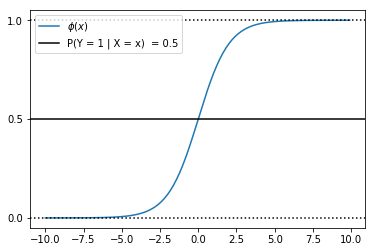

In [2]:
def sigmoid(x, lib=np):
    return 1/(1 + lib.exp(-x))
v = np.arange( -10, 10, 0.1)
plt.plot( v, sigmoid( v) , label="$\phi(x)$")
plt.axhline(0.0, ls='dotted', color='k')
plt.axhline(1.0, ls='dotted', color='k')
plt.axhline(0.5, color='k', label="P(Y = 1 | X = x)  = 0.5")
plt.yticks([0, 0.5, 1])
plt.legend()
plt.show()

Consideremos el caso simple de separar datos de dos Gaussianas

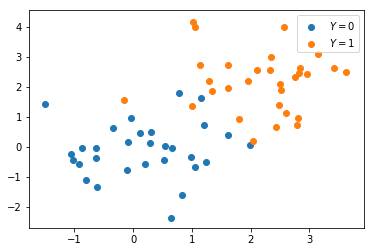

[1.17278253 1.02828968]


In [3]:
n_samples = 30
x1 = np.random.multivariate_normal(np.array([0,0]), np.array([[1,0], [0, 1]]), n_samples)
x2 = np.random.multivariate_normal(np.array([2,2]), np.array([[1,0], [0, 1]]), n_samples)

x = np.append(x1, x2, axis = 0)
# x = x - x.mean(axis=0) #centramos los datos para acelerar la convergencia
y = np.append([0] * len(x1) , [1] * len(x2)) # creamos nuestro vector de Y

plt.scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$")
plt.scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$")
plt.legend()
plt.show()

print(x.mean(axis=0))

Podemos hacer el ajuste de esta sigmoide minimizando el error de clasificación

$$ \min_{w}F(w) = \frac{1}{2} \sum_{i=1}^{m} (y_i - \phi(\mathbf{w}^T\mathbf{x}_i))^2 $$

donde $\mathbf{w}$ es un vector de pesos y $\mathbf{x}_i$ es nuestra variable en $\mathbb{R}^n$. Esto lo podemos resolver con el métdo de Levenberg-Marquardt ya que este sólo nos pide el Jacbobiano (primera derivada). En cada iteración del algoritmo LM se resuelve

$$ \min_{p} \frac{1}{2} ||J_kp+r_k||^2 \,\,\,\,\, ||p|| \leq \delta_k$$

donde $r_i = y_i - \phi(\mathbf{w}^T\mathbf{x}_i)$. Podemos ver que 
$$
\frac{\partial r_i}{\partial w_j} =  - \frac{\partial \phi(\mathbf{w}^T\mathbf{x}_i)}{\partial w_j} x_{i,j}$$ Donde 

\begin{align}
\frac{\partial{\phi(z)}}{\partial{z}} &= \frac{e^{-z}}{ (1 + e ^ {-z})^2}\\
&= \left(\frac{1}{1 + e^{-z}}\right)\left(\frac{1 - 1 + e^{-z}}{1 + e^{-z}}\right)\\
&= \phi(z)[1-\phi(z)]
\end{align}

Por lo cual
$$
\frac{\partial r_i}{\partial w_j} = - \phi(\mathbf{w}^T\mathbf{x}_i)[1 - \phi(\mathbf{w}^T\mathbf{x}_i)] x_{i,j}
$$

In [4]:
def logistic_function(x, w, lib=np):
    v = w[0]
    for i in range(len(x)):
        v += w[i+1] * x[i]
    return sigmoid(v, lib)
def R_sigmoid(y, x, w, lib=np):
    return logistic_function(x, w, lib=lib) - y

def __jacobiano_sigmoid(f, y, x, w):
    w_s = sp.symbols("w0:{}".format(len(w)))
    x_s = sp.symbols("x0:{}".format(len(w) - 1))
    y_s = sp.Symbol("y")
    mtx = sp.Matrix([f( y_s , x_s, w_s , lib=sp)]) #el reduce nos da la suma de todas las w[i]
    jac = mtx.jacobian(w_s)
    jac_f  = [sp.lambdify((x_s + w_s), jac[i]) for i in range(len(w))]
    def __do_grad(w):
        jac_eval = [ [jac_fn(*xi, *w) for jac_fn in jac_f] for xi in x]
        return np.array(jac_eval)
    return __do_grad

def __max_diag(A): #valor maximo en diagonal de matriz cuadrada
    l = A[0,0]
    for i in range(1, len(A)):
        l = A[i,i] if(A[i,i] > l) else l
    return l

In [5]:
def __R(y, x, w, lib=np):
    return np.array([ R_sigmoid(y[i], x[i], w, lib=lib) for i in range(len(x))])

def __LM(R, J, x, y, w, mk=100, toler = 1E-10, v=1.2):
    k = 0
    r = R(y, x, w)
    j = J(w)
    JJ = j.T@j
    l = __max_diag(JJ)
    norm_sq_r = r.T @ r
    b = j.T @r
    while np.linalg.norm( b ) > toler and k < mk:
        A = JJ + np.identity(JJ.shape[0]) * l
        p = np.linalg.solve(A, -b)
        nw = w + p
        nr = R(y, x, w)
        norm_sq_nr = nr.T @ nr
        if( norm_sq_nr <= norm_sq_r):
            norm_sq_r = norm_sq_nr
            r = nr
            w = nw
            l /= v
            j = J(w)
            JJ = j.T@j
            b = j.T @r
        else:
            l *= v
        k += 1
    return w

[-2.29746673  0.55968176  0.98821626]
CPU times: user 2.3 s, sys: 5.11 ms, total: 2.3 s
Wall time: 2.3 s


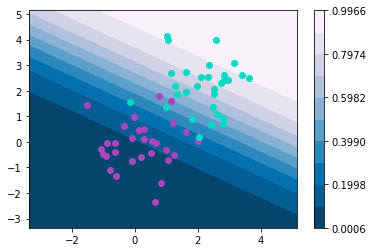

In [6]:
%%time
def rl_ls(y, x, k=10000): #encapsulamos la funcion para reusar facil
    w = np.append([0], [1] * x.shape[1])
    jf = __jacobiano_sigmoid(R_sigmoid, y, x, w)
    return __LM(__R, jf, x, y, w, k)
w = rl_ls(y, x)
print(w)

def eval_in_space(w):
    N = 100
    x_v = np.linspace(x.min()-1, x.max()+1, N)
    y_v = np.linspace(x.min()-1, x.max()+1, N)
    X_v, Y_v = np.meshgrid(x_v, y_v)
    XX = np.array([X_v.ravel(), Y_v.ravel()]).T
    Z = np.array([logistic_function(xi, w) for xi in XX])
    return X_v, Y_v, Z.reshape(X_v.shape)
X, Y, Z = eval_in_space(w)
cs = plt.contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
plt.scatter(x[:n_samples, 0], x[:n_samples, 1] , label = "$Y = 0$", color = '#AB47BC')
plt.scatter(x[n_samples:, 0], x[n_samples:, 1] , label = "$Y = 1$", color = '#03DAc6')
cbar = plt.colorbar(cs)

La regresión logistica también se puede hacer resolviendo el problema de optimizacíon dado por la función de máxima verosimilitud. Para esto consideramos que $p(y_i|\mathbf{x}_i ; \mathbf{w}) = y_i\phi(\mathbf{w}^T\mathbf{x}_i) + (1 - y_i)(1 - \phi(\mathbf{w}^T\mathbf{x}_i))$

donde $ x_i = [1, x_{i,0}, x_{i,1}, \cdots x_{i,m}]$

$$L(\mathbf{w}) = \prod_i^m p(y_i|\mathbf{x}_i ; \mathbf{w}) = \prod_{i = 0}^m  y_i\phi(\mathbf{w}^T\mathbf{x}_i) + (1 - y_i)(1 - \phi(\mathbf{w}^T\mathbf{x}_i))$$

In [7]:
def __verosimilitud__v1(y, x, w, f):
    l = 1
    for i in range(len(y)):
        fv = f(x[i], w)
        l *= (y[i] * fv + (1 - y[i])*(1 - fv))
    return l

Derivamos con $w_j$

$$\frac{\partial{p(y_i|\mathbf{x}_i ; \mathbf{w})}}{ \partial{w_j} } = 
y_i\phi(\mathbf{w}^T\mathbf{x}_i)[1 - \phi(\mathbf{w}^T\mathbf{x}_i)]x_{ij} - (1 - y_i)\phi(\mathbf{w}^T\mathbf{x}_i)[1 - \phi(\mathbf{w}^T\mathbf{x}_i)]x_{ij}
$$

$$ \frac{\partial{L(\mathbf{w})}}{ \partial{w_j} } = \sum_{i=0}^m
\left(
\frac{\partial{p(y_i|\mathbf{x}_i ; \mathbf{w})}}{ \partial{w_j} }
\prod_{k=0,k\neq i}^m p(y_k|\mathbf{x}_k ; \mathbf{w})
\right)
$$

In [8]:
def __grad_verosimilitud__v1(y, x, w, f):
    p_e = [(y[i] * f(x[i], w) + (1 - y[i])*(1 - f(x[i], w))) for i in range(len(y))]
    p_r = reduce(lambda x, y: x * y, p_e)
    
    gl = []
    for j in range(len(w)):
        l = 0
        for i in range(len(y)):
            fx  = f(x[i], w)
            xij = np.append([1], x[i])[j]
            lt  = y[i] * fx * (1 - fx) * xij - (1 - y[i]) * fx * (1 - fx) * xij
            l  += lt * p_r / p_e[i] 
        gl.append(l)
    return np.array(gl)

In [9]:
#gradiente de descenso con backtracking
def gdb(w, f, gf, params, a=1, m=1.5, k=1000):
    vw = f(w=w, **params) ## ** descomprime el diccionario
    for i in range(k):
        w1  = w + a * gf(w=w, **params)
        nvw = f(w=w1, **params)
        if(vw > nvw):
            a /= m #si no mejora queremos pasos mas pequeños
        else:
            a *= m #si mejora tomamos pasos mas grandes (podria ser despues de n pasos...)
            vw = nvw
            w = w1
    return w

[-5.4452788   2.28590554  2.55383451]


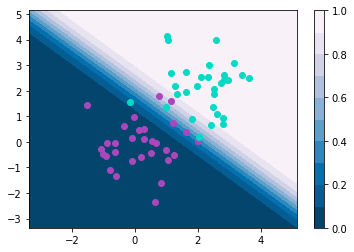

In [10]:
def rl_v1(y, x, k=1000): #podriamos exponer mas parametros...
    params = {'x':x, 'y':y, 'f':logistic_function}
    w = np.append([0], [1] * x.shape[1])
    w = gdb(w, 
            __verosimilitud__v1, 
            __grad_verosimilitud__v1,
            params, k=k)
    return w

w = rl_v1(y, x)
print(w)

X, Y, Z = eval_in_space(w)

cs = plt.contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
plt.scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$", color = '#AB47BC')
plt.scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$", color = '#03DAc6')
cbar = plt.colorbar(cs)

Como $y_i \in \{0,1\}$ es más sencillo si vemos $p(y_i|\mathbf{x}_i ; \mathbf{w}) = \phi(\mathbf{w}^T\mathbf{x}_i)^{y_i} + (1 - \phi(\mathbf{w}^T\mathbf{x}_i))^{1-y_i}$. Esto nos da 

$$L(w) =  \prod_{i = 0}^m  \phi(\mathbf{w}^T\mathbf{x}_i)^{y_i} + (1 - \phi(\mathbf{w}^T\mathbf{x}_i))^{(1 - y_i)}$$

dado que maximizar la verosimilitud equivale a maximizar la log-verosimilitud

$$\mathcal{l}(w) = \sum_{i = 0}^m  y_i\phi(\mathbf{w}^T\mathbf{x}_i) + (1 - y_i)(1 - \phi(\mathbf{w}^T\mathbf{x}_i))$$

In [11]:
def __log_verosimilitud(y, x, w, f):
    l = 0
    for i in range(len(y)):
        lf = np.log(f(x[i], w)) 
        l += (y[i] * lf + (1 - y[i])*(1 - lf))
    return l

Para obtener las derivadas parciales, primero consideramos 

\begin{align}
\frac{\partial}{\partial(z)} (y \log\phi(z) + (1-y)log[1 - \phi(z)]) &= \left(\frac{y}{\phi(z)} - \frac{1-y}{1-\phi(z)}\right)\frac{\partial\phi(z_i)}{\partial{w_j}}\\
&= \left(\frac{y}{\phi(z)} - \frac{1-y}{1-\phi(z)}\right)\phi(z)[1 - \phi(z)]\\
&= y[1 - \phi(z)] - (1 - y)\phi(z)\\
&= y - \phi(z)
\end{align}

Con esto podemos econtrar más facilmente la derivada parcial

\begin{align}
    \frac{\partial l(\mathbf{w})}{\partial w_j} &= \sum_{i=0}^m \frac{\partial}{\partial(z)} (y \log\phi(z) + (1-y)log[1 - \phi(z)]) \frac{\partial z_i}{\partial w_j}\\
    &= \sum_{i=0}^m [y_i - \phi(\mathbf{x}_i^T\mathbf{w})]x_{ij}
\end{align}

In [12]:
def __grad_log_verosimilitud(y, x, w, f):
    gl = np.zeros_like(w)
    for j in range(len(w)):
        l = 0
        for i in range(len(y)):
            fx  = f(x[i], w)
            xij = np.append([1], x[i])[j]
            l += (y[i] - fx) * xij
        gl[j] = l
    return np.array(gl)

In [13]:
__grad_log_verosimilitud(y, x, w, logistic_function)

array([-8.82094120e-09,  7.55899538e-08,  5.26171516e-08])

[-14.07075887   3.76917838   6.18913839]


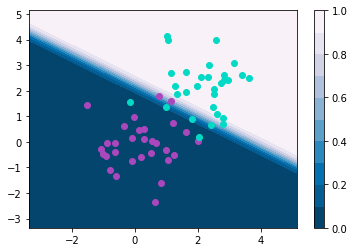

In [14]:
def rl_v2(y, x, k=1000): #podriamos exponer mas parametros...
    params = {'x':x, 'y':y, 'f':logistic_function}
    w = np.append([0], [1] * x.shape[1])
    w = gdb(w,
            __log_verosimilitud, 
            __grad_log_verosimilitud,
            params, k=k)
    return w

w = rl_v2(y, x)
print(w)

X, Y, Z = eval_in_space(w)

cs = plt.contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
plt.scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$", color = '#AB47BC')
plt.scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$", color = '#03DAc6')
cbar = plt.colorbar(cs)

Podemos comparar los resultados de los tres métodos de optimización. Para esto, consideramos las funciones de error

\begin{align}
\text{err}_1 &= \sum_{i=0}^m y_i \neq \lfloor\phi(\mathbf{w}^T\mathbf{x})\rceil \\
\text{err}_2 &= \sum_{i = 0}^m  y_i\phi(\mathbf{w}^T\mathbf{x}_i) + (1 - y_i)(1 - \phi(\mathbf{w}^T\mathbf{x}_i)) \\
\text{err}_3 &= \frac{1}{2} \sum_{i=1}^{m} (y_i - \phi(\mathbf{w}^T\mathbf{x}_i))^2
\end{align}

En la primera función penalizamos cada error con el mismo peso, mientras que en la segunda penalizamos más los errores más grandes, es decir, cuando clasificamos X como Y=1 con probabilidad alta

In [15]:
def err1(y, py):
    return sum(abs(y - np.round(np.array(py))))
def err2(y, py):
    err = 0
    for i in range(len(y)):
        err += y[i] * (1 - py[i]) + (1 - y[i]) * py[i]
    return err

def err3(y, py):
    err = 0
    for i in range(len(y)):
        err += (y[i] - py[i])**2
    return err

In [16]:
w = rl_ls(y, x), rl_v1(y, x), rl_v2(y, x)

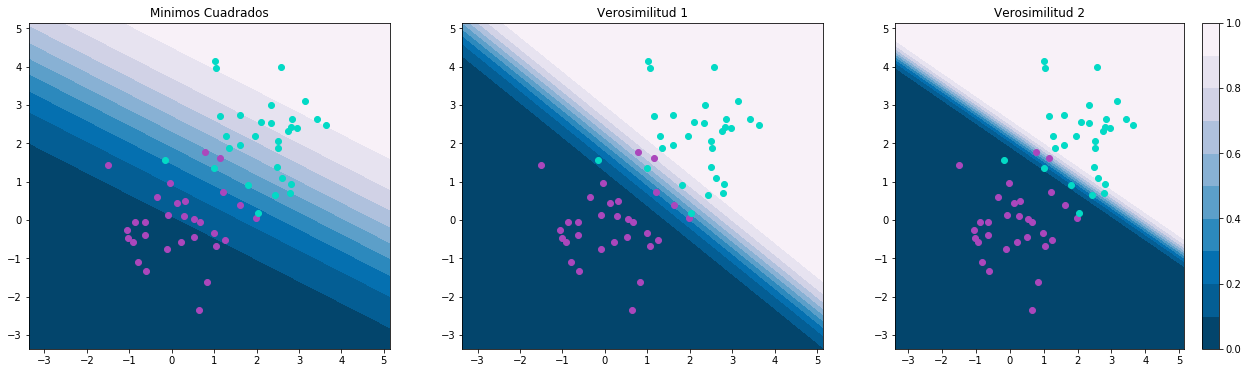

In [17]:
names = ['Minimos Cuadrados', "Verosimilitud 1", "Verosimilitud 2"]
f, ax = plt.subplots(1, len(w), figsize=(22, 6))
for i in range(len(w)):
    X, Y, Z = eval_in_space(w[i])
    cs = ax[i].contourf(X, Y, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
    ax[i].scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$", color = '#AB47BC')
    ax[i].scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$", color = '#03DAc6')
    ax[i].set_title(names[i])
plt.colorbar(cs)
plt.show()

In [18]:
py = [[logistic_function(xi, wi) for xi in x] for wi in w]
err1_v = [err1(y, pyi) for pyi in py]
err2_v = [err2(y, pyi) for pyi in py]
err3_v = [err3(y, pyi) for pyi in py]

for i in range(len(err1_v)):
    print(names[i], "\nError 1: ", err1_v[i], "Error 2:", err2_v[i], "Error 3:", err3_v[i])

Minimos Cuadrados 
Error 1:  6.0 Error 2: 12.868016318876874 Error 3: 4.773598073911724
Verosimilitud 1 
Error 1:  4.0 Error 2: 5.299443998586122 Error 3: 2.7971273937030325
Verosimilitud 2 
Error 1:  6.0 Error 2: 6.051006187283617 Error 3: 4.605548377023719


Como podemos ver, el desempeño es muy similar, pero el primer método de verosimilitud resulta superior.

Ya entendiendo el funcionamiento y viendo las gráficas en dos dimensiones, podemos 

In [68]:
x_i = iris.data
y_i = iris.target
x_i = np.append(x_i[y_i == 0],x_i[y_i == 2], axis=0)
y_i = np.append(y_i[y_i == 0],y_i[y_i == 2])
y_i[ y_i == 2] = 1

In [69]:
w_i = rl_ls(y_i, x_i, 20000), rl_v1(y_i, x_i), rl_v2(y_i, x_i)

In [70]:
py = [[logistic_function(xi, wi) for xi in x_i] for wi in w_i]
err1_v = [err1(y_i, pyi) for pyi in py]
err2_v = [err2(y_i, pyi) for pyi in py]
err3_v = [err3(y_i, pyi) for pyi in py]
for i in range(len(err1_v)):
    print(names[i], "\nError 1: ", err1_v[i], "Error 2:", err2_v[i], "Error 3:", err3_v[i])

Minimos Cuadrados 
Error 1:  50.0 Error 2: 50.0 Error 3: 50.0
Verosimilitud 1 
Error 1:  50.0 Error 2: 49.997322384815554 Error 3: 49.99463556822373
Verosimilitud 2 
Error 1:  0.0 Error 2: 1.160382532538892e-178 Error 3: 0.0


In [72]:
py[2]

In [53]:
w_i

(array([-189.19406875, -955.2115048 , -660.64525927, -283.47186144,
         -42.83831855]),
 array([-1.19257075e-42,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00]),
 array([ -265.53551796,  -211.4863745 , -1211.14598501,  2487.64959873,
         1197.34697851]))

In [61]:
x_i[:,:2]

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6],
       [5.4, 3.9],
       [4.6, 3.4],
       [5. , 3.4],
       [4.4, 2.9],
       [4.9, 3.1],
       [5.4, 3.7],
       [4.8, 3.4],
       [4.8, 3. ],
       [4.3, 3. ],
       [5.8, 4. ],
       [5.7, 4.4],
       [5.4, 3.9],
       [5.1, 3.5],
       [5.7, 3.8],
       [5.1, 3.8],
       [5.4, 3.4],
       [5.1, 3.7],
       [4.6, 3.6],
       [5.1, 3.3],
       [4.8, 3.4],
       [5. , 3. ],
       [5. , 3.4],
       [5.2, 3.5],
       [5.2, 3.4],
       [4.7, 3.2],
       [4.8, 3.1],
       [5.4, 3.4],
       [5.2, 4.1],
       [5.5, 4.2],
       [4.9, 3.1],
       [5. , 3.2],
       [5.5, 3.5],
       [4.9, 3.1],
       [4.4, 3. ],
       [5.1, 3.4],
       [5. , 3.5],
       [4.5, 2.3],
       [4.4, 3.2],
       [5. , 3.5],
       [5.1, 3.8],
       [4.8, 3. ],
       [5.1, 3.8],
       [4.6, 3.2],
       [5.3, 3.7],
       [5. , 3.3],
       [6.3, 3.3],
       [5.8, 2.7],
       [7.1,